In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

from glob import glob
from PIL import Image

from sklearn.feature_selection import f_classif, f_regression
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings(action='ignore')

# 한글 폰트 사용을 위해서 세팅
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## Data Load

In [2]:
train = pd.read_csv('./train.csv')
print(train.shape)
train.head(5)

(1000, 28)


,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [3]:
test = pd.read_csv("test.csv")

print(test.shape)
test.head(3)

(250, 26)


,ID,img_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,BC_01_0011,./test_imgs/BC_01_0011.png,55,2015-11-17,2,2,1,23.0,2.0,2.0,...,1.0,8.0,0.0,2.0,5.00,0.0,1.0,NaN,NaN,NaN
1,BC_01_0220,./test_imgs/BC_01_0220.png,43,2020-06-09,4,2,1,13.0,3.0,2.0,...,1.0,4.0,1.0,8.0,8.67,0.0,0.0,NaN,NaN,NaN
2,BC_01_0233,./test_imgs/BC_01_0233.png,76,2020-05-14,1,1,1,NaN,NaN,NaN,...,1.0,6.0,1.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN


In [4]:
submission = pd.read_csv("sample_submission.csv")

print(submission.shape)
submission.head(3)

(250, 2)


,ID,N_category
0,BC_01_0011,0
1,BC_01_0220,0
2,BC_01_0233,0


In [5]:
img_arrays = []

for fn in train["img_path"]:
    img = Image.open(fn)
    img_resize = img.resize((int(img.width / 4), int(img.height / 4)))
    img_arrays.append(np.array(img_resize))

train_img = np.array(img_arrays)    

In [6]:
len(train_img)

1000

In [7]:
img_arrays = []

for fn in test["img_path"]:
    img = Image.open(fn)
    img_resize = img.resize((int(img.width / 4), int(img.height / 4)))
    img_arrays.append(np.array(img_resize))


test_img = np.array(img_arrays)    

In [8]:
len(test_img)

250

## Simple Informations

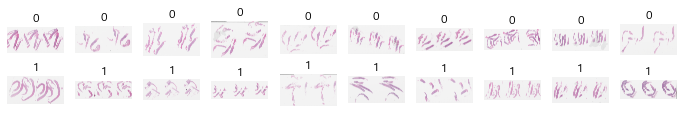

In [14]:
plt.figure(figsize=(12,10))

for n in range(0,2):  
    train_idx = train[train["N_category"] == n].tail(10).index
    for i, m in enumerate(train_idx):
        img = train_img[m]
        plt.subplot(11, 10, (n*10)+(i+1)) 
        plt.imshow(img, cmap=plt.cm.binary)
        plt.axis("off")
        plt.title(train.loc[m, "N_category"])

## All Image shows

label : 0


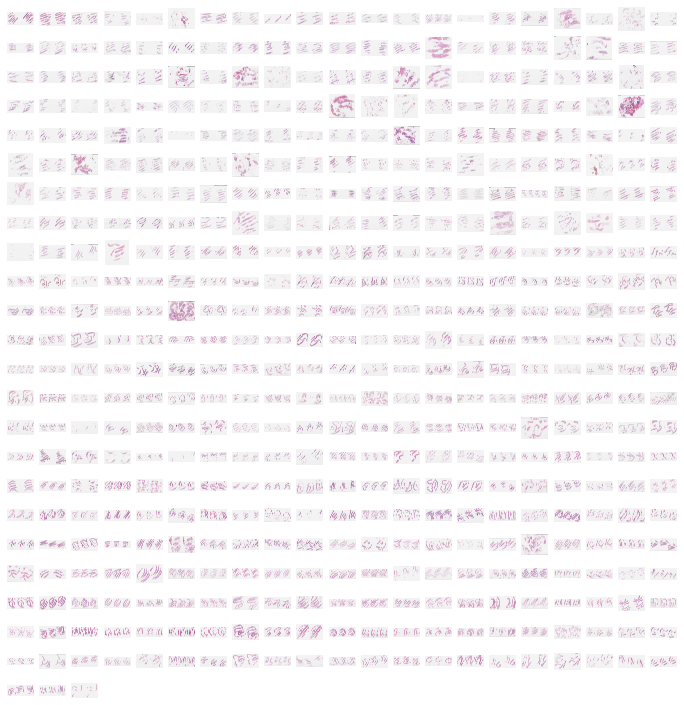

label : 1


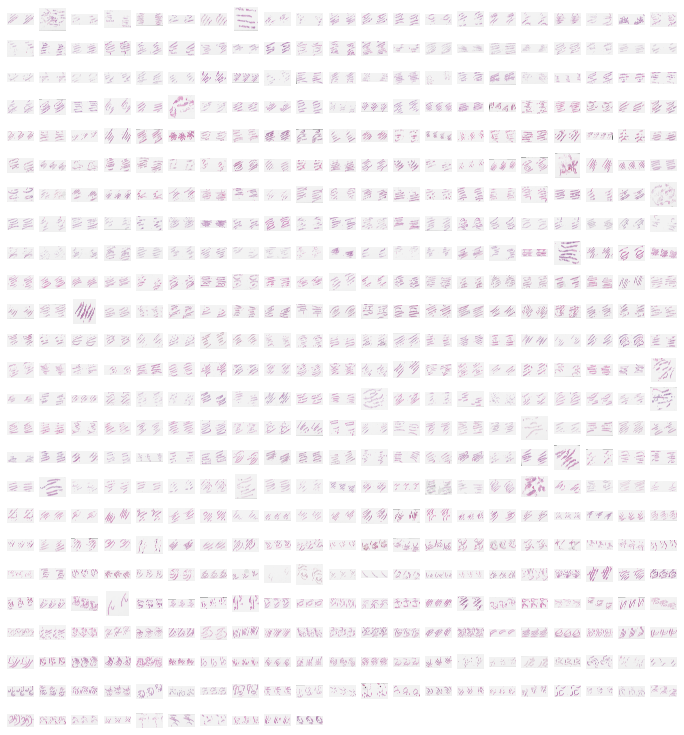

In [17]:
for n in range(0,2):  
    train_idx = train[train["N_category"] == n].index
    print(f"label : {n}")
    plt.figure(figsize=(12,30))
    
    for i, m in enumerate(train_idx):
        img = train_img[m]
        plt.subplot(56, 21, (i+1)) 
        plt.imshow(img)
        plt.axis("off")
    plt.show()  

## Simple CNN train

In [17]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch_optimizer as toptim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm
import timm.models.layers.activations as activations
import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder


from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [18]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':100,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':2,
    'SEED':41
}

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [20]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [21]:
train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())

train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED']
                                                )

In [8]:
class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        img_path = self.medical_df['img_path'].iloc[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image
        
    def __len__(self):
        return len(self.medical_df)

In [9]:
train_transforms = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transforms = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [10]:
train_dataset = CustomDataset(train_df, train_labels.values, train_transforms)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df, val_labels.values, test_transforms)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [11]:
class ImgFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImgFeatureExtractor, self).__init__()
        self.backbone = timm.create_model('tf_mobilenetv3_small_minimal_100', pretrained=True)
        self.embedding = nn.Linear(1000,512)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        return x

In [12]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.img_feature_extractor = ImgFeatureExtractor()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=1),
            nn.Sigmoid(),
        )

        
    def forward(self, img):
        img_feature = self.img_feature_extractor(img)
        output = self.classifier(img_feature)

        return output

In [13]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img = img.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred = model(img)

            loss = criterion(model_pred, label.reshape(-1,1))

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device)
    
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score < val_score:
            best_score = val_score
            best_model = model
    
    return best_model

In [14]:
def validation(model, criterion, val_loader, device):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = 0.5
    with torch.no_grad():
        for img, label in tqdm(iter(val_loader)):
            true_labels += label.tolist()
            
            img = img.float().to(device)

            label = label.float().to(device)
            model_pred = model(img)

            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    val_score = metrics.f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
    return np.mean(val_loss), val_score

In [15]:
model = nn.DataParallel(ClassificationModel())
model.eval()
optimizer = toptim.Ranger(model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-6, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.69554] Val Loss : [0.68450] Val Score : [0.33333]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.66113] Val Loss : [0.64548] Val Score : [0.68934]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.65693] Val Loss : [0.64017] Val Score : [0.66820]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.65749] Val Loss : [0.65369] Val Score : [0.69371]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.64623] Val Loss : [0.64254] Val Score : [0.65176]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.63552] Val Loss : [0.63884] Val Score : [0.61596]
Epoch     6: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.61660] Val Loss : [0.63434] Val Score : [0.71823]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.61443] Val Loss : [0.64276] Val Score : [0.66473]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.61504] Val Loss : [0.63927] Val Score : [0.68000]
Epoch     9: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.60589] Val Loss : [0.65522] Val Score : [0.71000]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.59725] Val Loss : [0.66962] Val Score : [0.66838]
Epoch    11: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.59659] Val Loss : [0.65681] Val Score : [0.68461]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.59986] Val Loss : [0.64828] Val Score : [0.66596]
Epoch    13: reducing learning rate of group 0 to 6.2500e-06.


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.58961] Val Loss : [0.64405] Val Score : [0.69160]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.58963] Val Loss : [0.64363] Val Score : [0.70333]
Epoch    15: reducing learning rate of group 0 to 3.1250e-06.


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.58896] Val Loss : [0.66075] Val Score : [0.64986]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.59009] Val Loss : [0.65705] Val Score : [0.65946]
Epoch    17: reducing learning rate of group 0 to 1.5625e-06.


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.58891] Val Loss : [0.64881] Val Score : [0.69438]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.58567] Val Loss : [0.64812] Val Score : [0.66518]
Epoch    19: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.58374] Val Loss : [0.66745] Val Score : [0.67480]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.58528] Val Loss : [0.64209] Val Score : [0.69562]


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.58640] Val Loss : [0.64982] Val Score : [0.67204]


  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 